## **Import**

In [3]:
! pip install tensorflow
! pip install tensorflow_datasets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

/Users/hyeokseung/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hyeokseung/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Download and prepare the dataset**

In [5]:
# Cats vs Dogs Dataset
tfds.disable_progress_bar()

splits = ['train[:10%]', 'train[10%:12%]', 'train[12%:14%]']

# load the dataset given the splits defined above
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

BATCH_SIZE = 64

def normalize_and_resize(image, label):
    image = tf.cast(image, tf.float32)

    # 이미지를 정규화 하세요 (픽셀값: 0~255)
    image = ## Your Code ##

    # 이미지를 224 x 224 사이즈로 Resize 하세요
    image = ## Your Code ##

    return image, label

# prepare batches
train_batches = train_examples.shuffle(num_examples // 4).map(normalize_and_resize).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_examples.map(normalize_and_resize).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

SyntaxError: invalid syntax (2838775247.py, line 20)

## **Modeling and Train**

In [ ]:
def build_model():
    base_model = tf.keras.applications.VGG16(input_shape= (224, 224, 3),
                                             weights='imagenet',
                                             include_top=False)

    # add a GAP layer
    output = ## Your Code ##

    # output has two neurons for the 2 classes(dogs and cats), Use softmax
    output = ## Your Code ##

    # set the inputs and outputs of the model
    model = tf.keras.Model(base_model.input, output)

    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    model.summary()

    return model

model = build_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
EPOCHS = 1
model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


37/37 [==============================] - 669s 18s/step - loss: 3.7844 - acc: 0.4871 - val_loss: 0.6932 - val_acc: 0.4882


## **Class Activation Map(CAM)**

In [ ]:
cam_model = tf.keras.Model(model.input, outputs=(model.layers[-3].output, model.layers[-1].output))
cam_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(512, 2)

In [ ]:
def show_cam(image_value, features, results, label):
    '''
    Displays the class activation map of an image
 
    Args:
        image_value (tensor) -- preprocessed input image with size 224 x 224
        features (array) -- features of the image, shape (1, 7, 7, 512)
        results (array) -- output of the sigmoid layer
    '''
    features_for_img = features[0]
    prediction = results[0]
 
    class_activation_weigths = gap_weights[:,label]
    class_activation_features = sp.ndimage.zoom(features_for_img, (224/7, 224/7, 1), order=2)
    
    # Class Activation Mapping을 통해 Class Activation Map을 구하여라 (Hint: Use np.dot, class_activation_weights, class_acitvation_features)
    cam_output = ## Your Code ##

    cam_output = tf.reshape(cam_output, (224,224))
 
    # visualize the results
    print(f'sigmoid output: {results}')
    print(f"prediction: {'dog' if tf.argmax(results[0]) else 'cat'}")
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()

In [ ]:
# preprocess the test images
augmented_test_data = test_examples.map(normalize_and_resize)
test_batches = augmented_test_data.batch(1)

NameError: name 'test_examples' is not defined

ground truth: dog
1/1 [==============================] - 0s 263ms/step
sigmoid output: [[0.5013959 0.4986041]]
prediction: cat


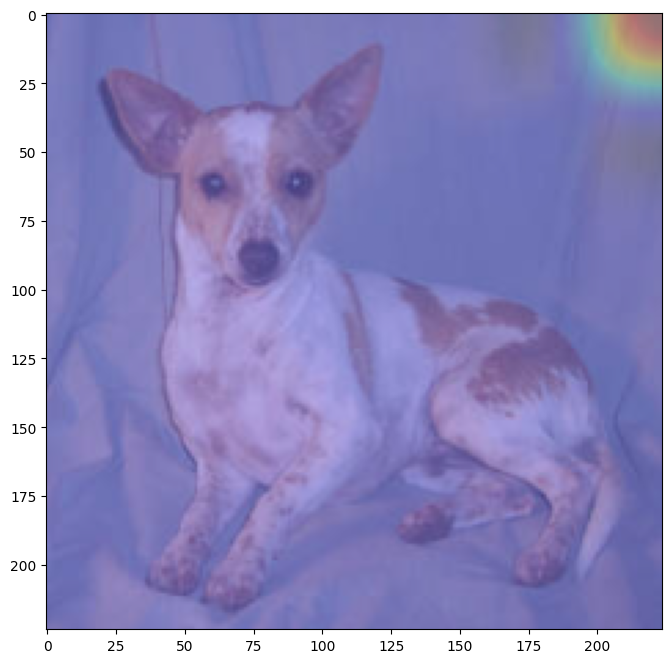

ground truth: dog
1/1 [==============================] - 0s 165ms/step
sigmoid output: [[0.50204265 0.49795732]]
prediction: cat


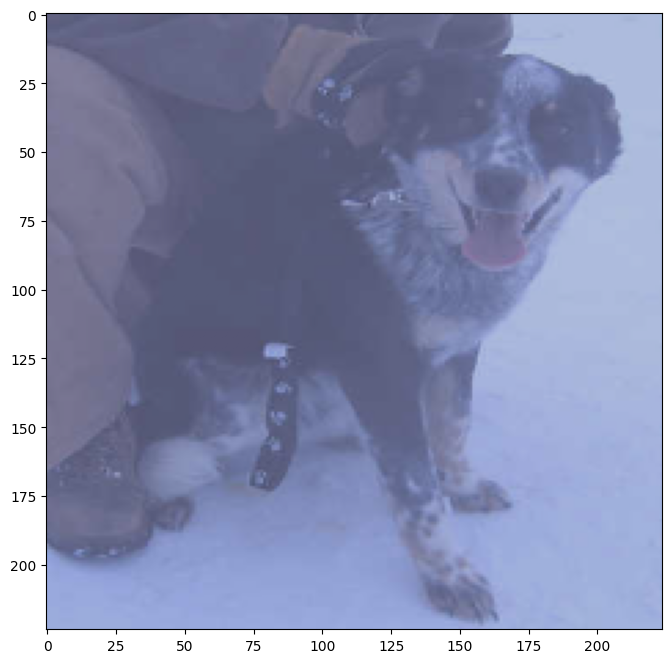

ground truth: dog
1/1 [==============================] - 0s 257ms/step
sigmoid output: [[0.50204265 0.49795732]]
prediction: cat


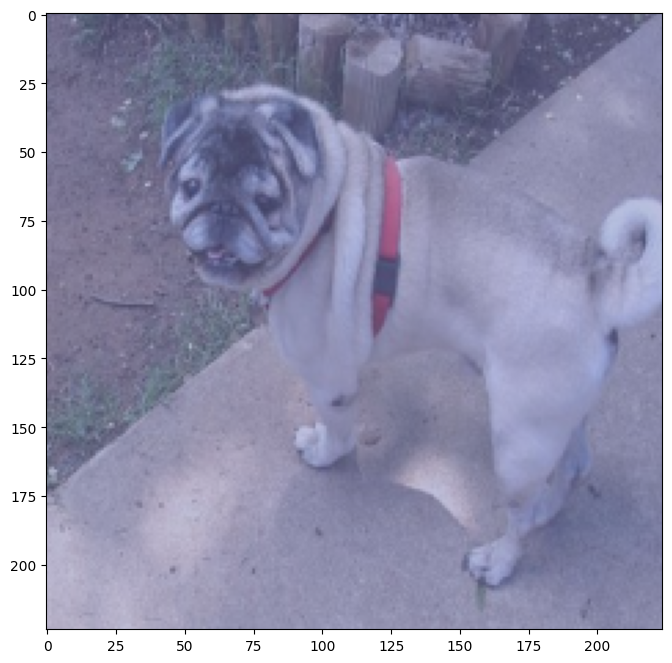

ground truth: cat
1/1 [==============================] - 0s 158ms/step
sigmoid output: [[0.5013154  0.49868456]]
prediction: cat


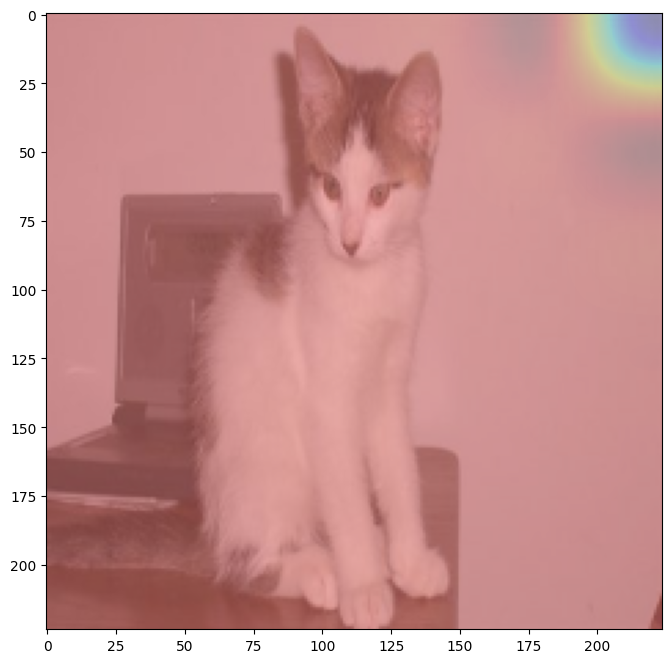

ground truth: cat
1/1 [==============================] - 0s 198ms/step
sigmoid output: [[0.50204265 0.49795732]]
prediction: cat


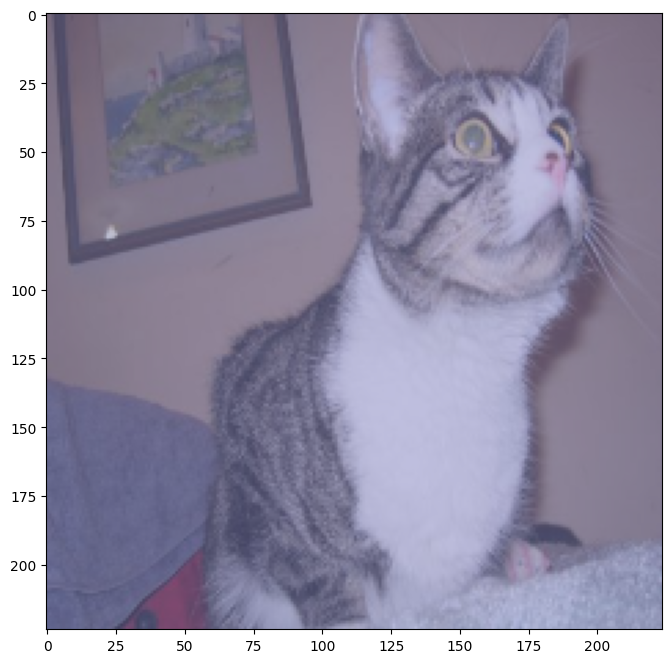

In [ ]:
for img, lbl in test_batches.take(5):
    print(f"ground truth: {'dog' if lbl else 'cat'}")
    features,results = cam_model.predict(img)
    show_cam(img, features, results, lbl)